In [119]:
import pandas as pd
import numpy as np
import copy

### Get data and remove the unnecessary columns

In [178]:
dataset = pd.read_csv('train_titanic.csv')

dataset['Sex'] = dataset['Sex'].replace(['female', 'male'], [0, 1]) 
dataset['Embarked'] = dataset['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2])
dataset['Embarked'] = dataset['Embarked'].fillna(int(dataset['Embarked'].mean()))
dataset['Age'] = dataset['Age'].fillna(int(dataset['Age'].mean()))
dataset['FamMemOnBoard'] = dataset['Parch'] + dataset['SibSp']

dataset.drop(['PassengerId', 'Name', 'Ticket', 'Parch', 'SibSp', 'Cabin'], axis=1, inplace=True)

dataset.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamMemOnBoard
0,0,3,1,22.0,7.2500,0.0,1
1,1,1,0,38.0,71.2833,1.0,1
2,1,3,0,26.0,7.9250,0.0,0
3,1,1,0,35.0,53.1000,0.0,1
4,0,3,1,35.0,8.0500,0.0,0


### Data visualization

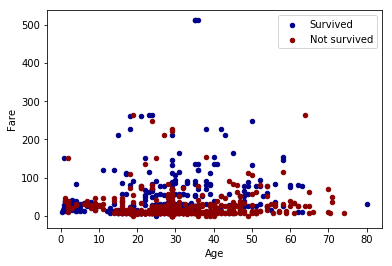

In [183]:
survivors = dataset[dataset['Survived'] == 1]
non_survivors = dataset[dataset['Survived'] == 0]

ax = survivors.plot.scatter(x='Age', y='Fare', color='DarkBlue', label='Survived')
non_survivors.plot.scatter(x='Age', y='Fare', color='DarkRed', label='Not survived', ax=ax)

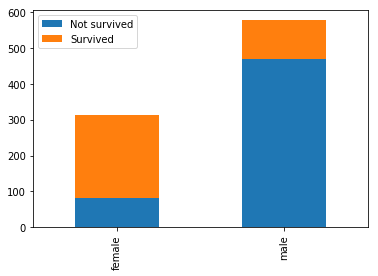

In [206]:
tmp = pd.DataFrame((dataset.groupby(['Sex','Survived'], as_index=False).count()))
index = ['female', 'male']

tb = pd.DataFrame({'Survived': tmp[tmp['Survived']==1]['Age'].values,
                  'Not survived': tmp[tmp['Survived']==0]['Age'].values}, 
                 index=index)
tb.plot.bar(stacked=True)

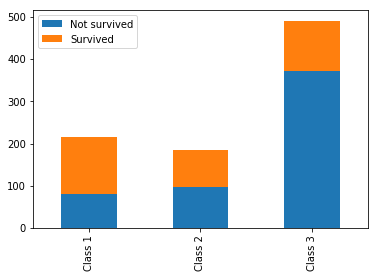

In [205]:
tmp = pd.DataFrame((dataset.groupby(['Pclass','Survived'], as_index=False).count()))
index = ['Class 1', 'Class 2', 'Class 3']

tb = pd.DataFrame({'Survived': tmp[tmp['Survived']==1]['Age'].values,
                  'Not survived': tmp[tmp['Survived']==0]['Age'].values}, 
                 index=index)
tb.plot.bar(stacked=True)

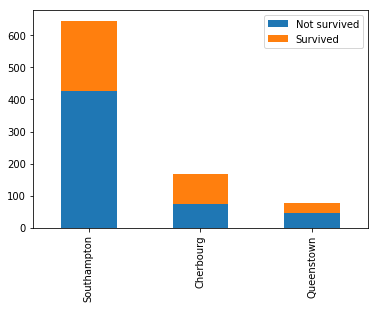

In [208]:
tmp = pd.DataFrame((dataset.groupby(['Embarked','Survived'], as_index=False).count()))
index = ['Southampton', 'Cherbourg', 'Queenstown']

tb = pd.DataFrame({'Survived': tmp[tmp['Survived']==1]['Age'].values,
                  'Not survived': tmp[tmp['Survived']==0]['Age'].values}, 
                 index=index)
tb.plot.bar(stacked=True)

### Split data in training and validation dataset

In [201]:
numeric_datapoints = dataset[['Pclass', 'Age', 'Fare', 'FamMemOnBoard', 'Sex', 'Embarked']]
targets = dataset['Survived']

training_dataset_size = int(numeric_datapoints.shape[0] * 0.9)
training_points = numeric_datapoints.head(training_dataset_size)
training_labels = targets.head(training_dataset_size)

validation_dataset_size = int(numeric_datapoints.shape[0] - training_dataset_size)
validation_points = numeric_datapoints.tail(validation_dataset_size).reset_index(drop = True)
validation_labels = targets.tail(validation_dataset_size).reset_index(drop = True)

### Decision trees for classification

In [202]:
import decision_trees
m_tree = decision_trees.ClassificationDecisionTree()
m_tree.train(training_points, training_labels, max_depth = 6)

In [46]:
def check_accuracy(tree, data, labels):
    positives = np.sum([labels.loc[i] == int(tree.predict(data.loc[[i]])) for i in range(data.shape[0])])
    return int( (positives / data.shape[0]) * 100)

def calculate_error(prunned_subtree, test_data, test_labels):
    while prunned_subtree.parent is not None:
        prunned_subtree = prunned_subtree.parent
    return 100 - check_accuracy(prunned_subtree, test_data, test_labels)
    
def reduced_error_pruning(tree, best_tree, best_error, test_data, test_labels):
    # Recursion anchor
    if tree.right is None:
        return best_tree, best_error
    
    # Prunning current subtree
    prunned_tree = copy.deepcopy(tree)
    
    prunned_tree.right = None
    prunned_tree.left = None
    prunned_tree.label = str(decision_trees.ClassificationDecisionTree.dominatingClass(test_labels))
    prunned_tree_error = calculate_error(prunned_tree, test_data, test_labels)
    
    if prunned_tree_error < best_error:
        best_tree = prunned_tree
        best_error = prunned_tree_error

    # Recursive call
    reduced_error_pruning(tree.right, best_tree, best_error, test_data, test_labels)
    reduced_error_pruning(tree.left, best_tree, best_error, test_data, test_labels)

In [118]:
print('Accuracy: {} %'.format(check_accuracy(m_tree, validation_points, validation_labels)))

Accuracy: 85 %


### Test the algorithm on the test set

In [119]:
test = pd.read_csv('test_titanic.csv')

test['Sex'] = test['Sex'].replace(['female', 'male'], [0, 1])
test['Embarked'] = test['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2]) 
test['Age'] = test['Age'].fillna(int(test['Age'].mean()))
test['Fare'] = np.log1p(test['Fare'])

test_important = test[['Pclass', 'Age', 'SibSp', 'Fare', 'Parch', 'Sex', 'Embarked']]

m_answer = pd.DataFrame()
for i in range(test.shape[0]):
    prediction = int(m_tree.predict(test_important.loc[[i]]))
    passenger_id = int(test.loc[i,'PassengerId'])
    m_answer = m_answer.append({'PassengerId':test.loc[i,'PassengerId'], 'Survived': prediction},ignore_index=True)
m_answer = m_answer.astype('int32')

In [120]:
m_answer.to_csv('titanic-dt.csv',index=False)